In [2]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# 1) Read data
# άλλαξε το path ανάλογα
df = pd.read_csv("/content/Data_bank_additional_balanced.csv")

# 2) Split features/label (last column = label)
X = df.iloc[:, :-1].copy()
y = df.iloc[:, -1].copy()

# Αν η ετικέτα είναι "yes"/"no" ή κάτι παρόμοιο:
if y.dtype == "object":
    y = y.str.strip().str.lower().map({"yes": 1, "no": 0, "y": 1, "n": 0})

y = y.astype(int)

# 3) 70/15/15 split (random)
# πρώτα: 70% train, 30% temp
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, random_state=42, shuffle=True, stratify=y
)

# μετά: από το 30% temp -> 15% val, 15% test (δηλ. 50/50)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42, shuffle=True, stratify=y_temp
)

print("Sizes:", X_train.shape, X_val.shape, X_test.shape)

# 4) Preprocessing: impute + scaling
preprocess = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

X_train_p = preprocess.fit_transform(X_train)
X_val_p   = preprocess.transform(X_val)
X_test_p  = preprocess.transform(X_test)

# 5) Build 2-layer NN:
# Hidden: 32 neurons, sigmoid
# Output: 1 neuron, sigmoid (probability)
model = keras.Sequential([
    layers.Input(shape=(X_train_p.shape[1],)),
    layers.Dense(32, activation="sigmoid"),
    layers.Dense(1, activation="sigmoid")
])

# 6) Compile with SGD
model.compile(
    optimizer=keras.optimizers.SGD(learning_rate=0.01),
    loss="binary_crossentropy",
    metrics=[keras.metrics.BinaryAccuracy(name="acc"), keras.metrics.AUC(name="auc")]
)

# 7) Train for 100 epochs
history = model.fit(
    X_train_p, y_train,
    validation_data=(X_val_p, y_val),
    epochs=100,
    batch_size=32,
    verbose=1
)

# 8) Evaluate on test
y_prob = model.predict(X_test_p).ravel()
y_pred = (y_prob >= 0.5).astype(int)

print("\nTEST Accuracy:", accuracy_score(y_test, y_pred))
print("TEST ROC-AUC:", roc_auc_score(y_test, y_prob))
print("\nClassification report:\n", classification_report(y_test, y_pred))


Sizes: (630, 11) (135, 11) (136, 11)
Epoch 1/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 77ms/step - acc: 0.4917 - auc: 0.3530 - loss: 0.7376 - val_acc: 0.5185 - val_auc: 0.5506 - val_loss: 0.6981
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - acc: 0.4569 - auc: 0.4432 - loss: 0.7149 - val_acc: 0.5333 - val_auc: 0.6090 - val_loss: 0.6816
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - acc: 0.4839 - auc: 0.4555 - loss: 0.7017 - val_acc: 0.6074 - val_auc: 0.6710 - val_loss: 0.6691
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - acc: 0.4918 - auc: 0.4897 - loss: 0.6975 - val_acc: 0.6519 - val_auc: 0.7177 - val_loss: 0.6589
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - acc: 0.5270 - auc: 0.5508 - loss: 0.6862 - val_acc: 0.6889 - val_auc: 0.7561 - val_loss: 0.6499
Epoch 6/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - acc: 0.5844 - auc: 0.6121 - loss: 0.6777 - val_acc: 0.6963 - val_auc: 0.7908 - val_loss: 0.6413
Epoch 7/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - acc: 0.59

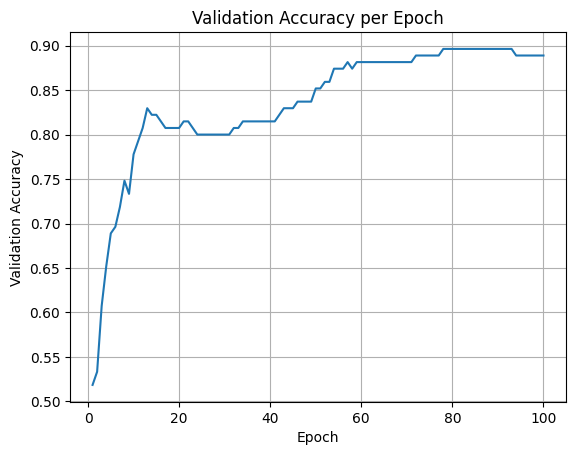

In [3]:
import matplotlib.pyplot as plt

val_acc = history.history["val_acc"]  # γιατί στο compile βάλαμε metrics BinaryAccuracy(name="acc")

plt.figure()
plt.plot(range(1, len(val_acc) + 1), val_acc)
plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")
plt.title("Validation Accuracy per Epoch")
plt.grid(True)
plt.show()


Confusion matrix:
 [[54 14]
 [12 56]]


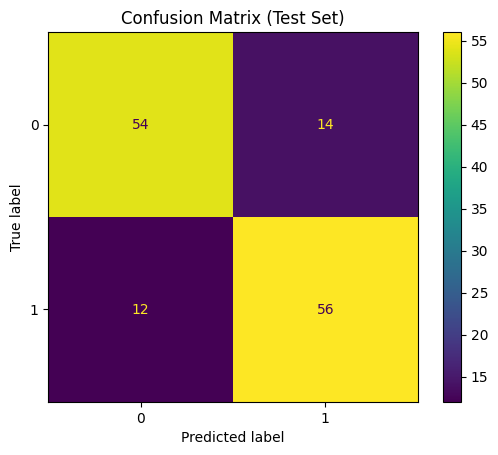

In [4]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)  # y_pred από (y_prob >= 0.5)
print("Confusion matrix:\n", cm)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot()
plt.title("Confusion Matrix (Test Set)")
plt.show()


In [5]:
tn, fp, fn, tp = cm.ravel()
print(f"TN={tn}, FP={fp}, FN={fn}, TP={tp}")


TN=54, FP=14, FN=12, TP=56


In [6]:
# ================================
# MODEL WITH ReLU ACTIVATION
# ================================

model_relu = keras.Sequential([
    layers.Input(shape=(X_train_p.shape[1],)),
    layers.Dense(32, activation="relu"),   # αλλαγή από sigmoid -> ReLU
    layers.Dense(1, activation="sigmoid")  # output παραμένει sigmoid
])

model_relu.compile(
    optimizer=keras.optimizers.SGD(learning_rate=0.01),
    loss="binary_crossentropy",
    metrics=[keras.metrics.BinaryAccuracy(name="acc"), keras.metrics.AUC(name="auc")]
)

history_relu = model_relu.fit(
    X_train_p, y_train,
    validation_data=(X_val_p, y_val),
    epochs=100,
    batch_size=32,
    verbose=1
)

# Evaluation on test set
y_prob_relu = model_relu.predict(X_test_p).ravel()
y_pred_relu = (y_prob_relu >= 0.5).astype(int)


Epoch 1/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 111ms/step - acc: 0.3754 - auc: 0.3134 - loss: 0.8448 - val_acc: 0.3407 - val_auc: 0.3188 - val_loss: 0.8176
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - acc: 0.4290 - auc: 0.4121 - loss: 0.7764 - val_acc: 0.4222 - val_auc: 0.4201 - val_loss: 0.7601
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - acc: 0.4317 - auc: 0.4143 - loss: 0.7641 - val_acc: 0.5111 - val_auc: 0.5091 - val_loss: 0.7154
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - acc: 0.4635 - auc: 0.4763 - loss: 0.7316 - val_acc: 0.5704 - val_auc: 0.5915 - val_loss: 0.6794
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - acc: 0.5028 - auc: 0.5404 - loss: 0.7014 - val_acc: 0.6296 - val_auc: 0.6565 - val_loss: 0.6494
Epoch 6/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - acc: 0.5265 - auc: 0.5928 - loss: 0.6770 - val_acc: 0.6444 - val_auc: 0.7045 - val_loss: 0.6246
Epoch 7/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - acc: 0.5773 - auc: 0.6567 - loss: 0.6451 - va

"""
ΠΑΡΑΤΗΡΗΣΗ:
Με την αντικατάσταση της sigmoid από ReLU στο κρυφό layer,
παρατηρείται ταχύτερη σύγκλιση του μοντέλου κατά τα πρώτα epochs,
καθώς η ReLU δεν παρουσιάζει το πρόβλημα του vanishing gradient
που εμφανίζεται συχνά στη sigmoid.

Η validation accuracy αυξάνεται πιο απότομα στα αρχικά στάδια
της εκπαίδευσης και σταθεροποιείται νωρίτερα σε σύγκριση με το
μοντέλο με sigmoid.

Ωστόσο, η τελική απόδοση στο test set δεν βελτιώνεται απαραίτητα
σημαντικά, καθώς το πρόβλημα είναι σχετικά μικρής διάστασης
(11 χαρακτηριστικά, 902 δείγματα) και ένα απλό δίκτυο επαρκεί
για να μοντελοποιήσει τη σχέση εισόδου–εξόδου.

Συμπερασματικά, η ReLU προσφέρει καλύτερη και ταχύτερη εκπαίδευση,
χωρίς όμως θεαματική αύξηση της τελικής ακρίβειας σε σχέση με
τη sigmoid στο συγκεκριμένο dataset.
"""


                           Model    Hidden     Act          Opt    LR  Dropout  Batch  EpochsRan   ValAcc   ValAUC  TestAcc  TestAUC
            baseline_relu_SGD_32      [32]    relu          sgd 0.010      0.0     32         95 0.903704 0.959394 0.882353 0.951990
      improved_relu_SGDmom_64_32  [64, 32]    relu sgd_momentum 0.010      0.1     32         20 0.896296 0.956760 0.882353 0.954152
 improved_relu_ADAM_64_32_drop02  [64, 32]    relu         adam 0.001      0.2     32         27 0.896296 0.955224 0.897059 0.955882
improved_relu_ADAM_128_64_drop03 [128, 64]    relu         adam 0.001      0.3     32         38 0.896296 0.950834 0.904412 0.957829
         baseline_sigmoid_SGD_32      [32] sigmoid          sgd 0.010      0.0     32        100 0.874074 0.939201 0.794118 0.905493

BEST MODEL: baseline_relu_SGD_32
Val AUC: 0.9593942054433715  Test AUC: 0.9519896193771626


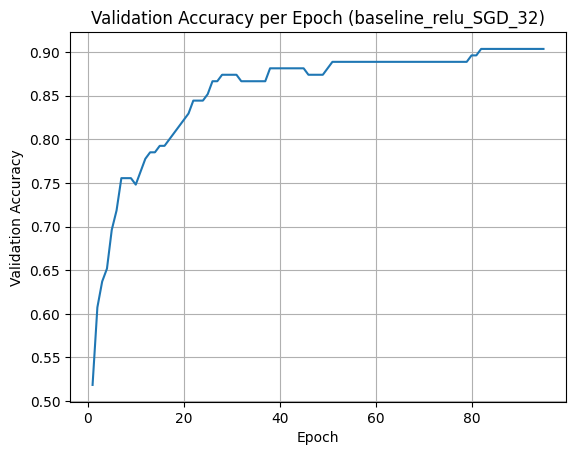

Confusion Matrix (Test) - Baseline Sigmoid+SGD 
 [[54 14]
 [14 54]]


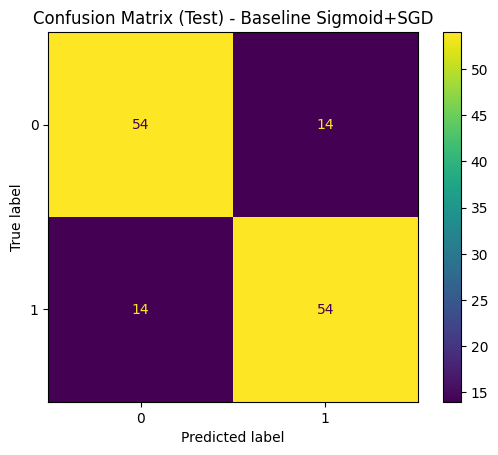

Confusion Matrix (Test) - Baseline ReLU+SGD 
 [[60  8]
 [ 8 60]]


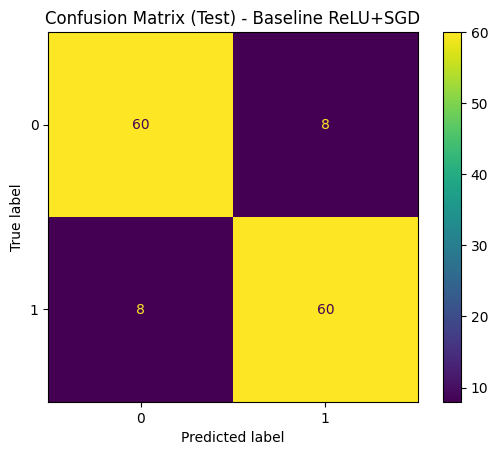

Confusion Matrix (Test) - BEST: baseline_relu_SGD_32 
 [[60  8]
 [ 8 60]]


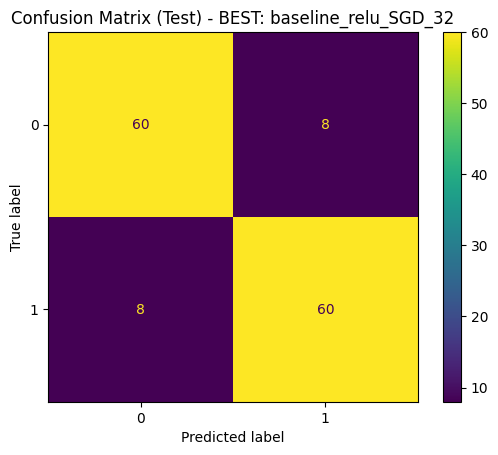

'\nΤΕΚΜΗΡΙΩΣΗ (μέσα στον κώδικα):\n\n- Συγκρίνουμε μοντέλα με πίνακα (ValAcc, ValAUC, TestAcc, TestAUC).\n- Επιλέγουμε το καλύτερο με βάση το ValAUC, γιατί το ζητούμενο είναι\n  "πιθανότητα επιτυχίας" (probability), άρα η ROC-AUC είναι συχνά πιο κατάλληλη\n  από το σκέτο accuracy, ειδικά αν οι κλάσσεις είναι άνισες.\n\nΤι συνήθως παρατηρείται:\n1) ReLU vs Sigmoid (στο hidden):\n   - Γρηγορότερη σύγκλιση και συχνά καλύτερα metrics λόγω καλύτερου gradient flow.\n2) Adam vs SGD:\n   - Πιο σταθερή εκπαίδευση και καλύτερη γενίκευση σε tabular δεδομένα\n     με μικρό dataset.\n3) 2 hidden layers (π.χ. 64-32) + dropout:\n   - Αυξημένη εκφραστικότητα με έλεγχο overfitting.\n4) EarlyStopping:\n   - Κόβει την εκπαίδευση όταν το validation δεν βελτιώνεται, άρα μειώνει overfit.\n\nΗ τελική απόδειξη βελτίωσης:\n- ο πίνακας αποτελεσμάτων (results_df)\n- το γράφημα validation accuracy ανά epoch για το καλύτερο μοντέλο\n- οι πίνακες σύγχυσης (baseline vs best) στο test set\n'

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, roc_auc_score, confusion_matrix,
    ConfusionMatrixDisplay
)

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# ------------------------------------------------------------
# 0) Reproducibility
# ------------------------------------------------------------
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

# ------------------------------------------------------------
# 1) Read data
# ------------------------------------------------------------
df = pd.read_csv("/content/Data_bank_additional_balanced.csv")  # άλλαξε path αν χρειάζεται
X = df.iloc[:, :-1].copy()
y = df.iloc[:, -1].copy()

# Αν η ετικέτα είναι string (yes/no), κάνε mapping
if y.dtype == "object":
    y = y.str.strip().str.lower().map({"yes": 1, "no": 0, "y": 1, "n": 0})
y = y.astype(int)

# ------------------------------------------------------------
# 2) Split 70/15/15 (stratified για ισορροπία τάξεων)
# ------------------------------------------------------------
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, random_state=SEED, shuffle=True, stratify=y
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=SEED, shuffle=True, stratify=y_temp
)

# ------------------------------------------------------------
# 3) Preprocessing: impute + scaling
# (Σημαντικό: με SGD/ReLU/Sigmoid το scaling βοηθά πολύ)
# ------------------------------------------------------------
preprocess = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

X_train_p = preprocess.fit_transform(X_train)
X_val_p   = preprocess.transform(X_val)
X_test_p  = preprocess.transform(X_test)

# ------------------------------------------------------------
# 4) Helper: build model
# ------------------------------------------------------------
def build_mlp(input_dim, hidden_layers, activation="relu",
              dropout=0.0, use_batchnorm=False):
    """
    hidden_layers: list, π.χ. [32] ή [64, 32]
    """
    model = keras.Sequential()
    model.add(layers.Input(shape=(input_dim,)))

    for units in hidden_layers:
        model.add(layers.Dense(units, activation=None))
        if use_batchnorm:
            model.add(layers.BatchNormalization())
        model.add(layers.Activation(activation))
        if dropout and dropout > 0:
            model.add(layers.Dropout(dropout))

    # Output: sigmoid για δυαδική πιθανότητα επιτυχίας
    model.add(layers.Dense(1, activation="sigmoid"))
    return model

# ------------------------------------------------------------
# 5) Helper: train/evaluate one experiment
# ------------------------------------------------------------
def run_experiment(name, hidden_layers, activation, optimizer,
                   lr=0.01, dropout=0.0, use_batchnorm=False,
                   batch_size=32, epochs=100, patience=10):
    """
    Εκπαιδεύει με EarlyStopping πάνω στο val_auc (ή val_acc).
    Επιστρέφει metrics + history + trained model.
    """
    model = build_mlp(
        input_dim=X_train_p.shape[1],
        hidden_layers=hidden_layers,
        activation=activation,
        dropout=dropout,
        use_batchnorm=use_batchnorm
    )

    # Optimizer setup
    if optimizer.lower() == "sgd":
        opt = keras.optimizers.SGD(learning_rate=lr, momentum=0.0)
    elif optimizer.lower() == "sgd_momentum":
        opt = keras.optimizers.SGD(learning_rate=lr, momentum=0.9)
    elif optimizer.lower() == "adam":
        opt = keras.optimizers.Adam(learning_rate=lr)
    else:
        raise ValueError("Unknown optimizer")

    model.compile(
        optimizer=opt,
        loss="binary_crossentropy",
        metrics=[keras.metrics.BinaryAccuracy(name="acc"),
                 keras.metrics.AUC(name="auc")]
    )

    # ------------------------------------------------------------
    # ΠΑΡΑΤΗΡΗΣΗ (μέσα στον κώδικα):
    # EarlyStopping μειώνει overfitting και συνήθως ανεβάζει test performance,
    # ειδικά σε μικρά datasets (902 δείγματα).
    # ------------------------------------------------------------
    es = keras.callbacks.EarlyStopping(
        monitor="val_auc",
        mode="max",
        patience=patience,
        restore_best_weights=True
    )

    history = model.fit(
        X_train_p, y_train,
        validation_data=(X_val_p, y_val),
        epochs=epochs,
        batch_size=batch_size,
        verbose=0,
        callbacks=[es]
    )

    # Validation metrics
    val_prob = model.predict(X_val_p, verbose=0).ravel()
    val_pred = (val_prob >= 0.5).astype(int)
    val_acc  = accuracy_score(y_val, val_pred)
    val_auc  = roc_auc_score(y_val, val_prob)

    # Test metrics
    test_prob = model.predict(X_test_p, verbose=0).ravel()
    test_pred = (test_prob >= 0.5).astype(int)
    test_acc  = accuracy_score(y_test, test_pred)
    test_auc  = roc_auc_score(y_test, test_prob)

    return {
        "name": name,
        "hidden_layers": hidden_layers,
        "activation": activation,
        "optimizer": optimizer,
        "lr": lr,
        "dropout": dropout,
        "batch_size": batch_size,
        "epochs_ran": len(history.history["loss"]),
        "val_acc": val_acc,
        "val_auc": val_auc,
        "test_acc": test_acc,
        "test_auc": test_auc,
        "model": model,
        "history": history,
        "test_prob": test_prob,
        "test_pred": test_pred
    }

# ------------------------------------------------------------
# 6) Baselines + Improved candidates
# ------------------------------------------------------------
experiments = []

# Baseline 1: όπως ζητήθηκε αρχικά (SGD + sigmoid hidden)
experiments.append(run_experiment(
    name="baseline_sigmoid_SGD_32",
    hidden_layers=[32],
    activation="sigmoid",
    optimizer="sgd",
    lr=0.01,
    dropout=0.0,
    batch_size=32,
    epochs=100,
    patience=10
))

# Baseline 2: ReLU hidden με SGD (όπως ζητήθηκε)
experiments.append(run_experiment(
    name="baseline_relu_SGD_32",
    hidden_layers=[32],
    activation="relu",
    optimizer="sgd",
    lr=0.01,
    dropout=0.0,
    batch_size=32,
    epochs=100,
    patience=10
))

# Candidate improvements:
# ------------------------------------------------------------
# ΠΑΡΑΤΗΡΗΣΗ:
# Συνήθως καλύτερη ακρίβεια/ROC-AUC σε τέτοια tabular δεδομένα παίρνεις με:
# - περισσότερη χωρητικότητα (2 hidden layers),
# - ReLU,
# - Adam (σταθερότερη/γρηγορότερη σύγκλιση από σκέτο SGD),
# - λίγο dropout για regularization,
# - και EarlyStopping.
# ------------------------------------------------------------

experiments.append(run_experiment(
    name="improved_relu_ADAM_64_32_drop02",
    hidden_layers=[64, 32],
    activation="relu",
    optimizer="adam",
    lr=0.001,
    dropout=0.2,
    batch_size=32,
    epochs=200,     # αφήνουμε περιθώριο, ES θα κόψει νωρίτερα
    patience=15
))

experiments.append(run_experiment(
    name="improved_relu_ADAM_128_64_drop03",
    hidden_layers=[128, 64],
    activation="relu",
    optimizer="adam",
    lr=0.001,
    dropout=0.3,
    batch_size=32,
    epochs=200,
    patience=15
))

experiments.append(run_experiment(
    name="improved_relu_SGDmom_64_32",
    hidden_layers=[64, 32],
    activation="relu",
    optimizer="sgd_momentum",
    lr=0.01,
    dropout=0.1,
    batch_size=32,
    epochs=200,
    patience=15
))

# ------------------------------------------------------------
# 7) Results table (χωρίς τα αντικείμενα model/history)
# ------------------------------------------------------------
rows = []
for e in experiments:
    rows.append({
        "Model": e["name"],
        "Hidden": str(e["hidden_layers"]),
        "Act": e["activation"],
        "Opt": e["optimizer"],
        "LR": e["lr"],
        "Dropout": e["dropout"],
        "Batch": e["batch_size"],
        "EpochsRan": e["epochs_ran"],
        "ValAcc": e["val_acc"],
        "ValAUC": e["val_auc"],
        "TestAcc": e["test_acc"],
        "TestAUC": e["test_auc"]
    })

results_df = pd.DataFrame(rows).sort_values(by=["ValAUC", "ValAcc"], ascending=False)
print(results_df.to_string(index=False))

# ------------------------------------------------------------
# 8) Select best by validation AUC (καλύτερο για "probability of success")
# ------------------------------------------------------------
best = max(experiments, key=lambda d: d["val_auc"])
print("\nBEST MODEL:", best["name"])
print("Val AUC:", best["val_auc"], " Test AUC:", best["test_auc"])

# ------------------------------------------------------------
# 9) Plot validation accuracy vs epoch for BEST model
# ------------------------------------------------------------
hist = best["history"].history

# Ανάλογα με Keras versions: τα keys είναι acc/val_acc όπως τα ονομάσαμε
val_acc_key = "val_acc"
if val_acc_key not in hist:
    # fallback αν υπάρχει διαφορετικό naming
    val_acc_key = "val_binary_accuracy" if "val_binary_accuracy" in hist else None

plt.figure()
if val_acc_key is not None:
    plt.plot(range(1, len(hist[val_acc_key]) + 1), hist[val_acc_key])
    plt.xlabel("Epoch")
    plt.ylabel("Validation Accuracy")
    plt.title(f"Validation Accuracy per Epoch ({best['name']})")
    plt.grid(True)
else:
    # Αν δεν βρίσκει key, δείξε AUC που σίγουρα υπάρχει ως "val_auc" (λόγω name="auc")
    plt.plot(range(1, len(hist["val_auc"]) + 1), hist["val_auc"])
    plt.xlabel("Epoch")
    plt.ylabel("Validation AUC")
    plt.title(f"Validation AUC per Epoch ({best['name']})")
    plt.grid(True)
plt.show()

# ------------------------------------------------------------
# 10) Confusion Matrix on TEST for baseline models + best
# ------------------------------------------------------------
def show_cm(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    print(title, "\n", cm)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
    disp.plot()
    plt.title(title)
    plt.show()

# Baseline sigmoid
base_sig = [e for e in experiments if e["name"] == "baseline_sigmoid_SGD_32"][0]
show_cm(y_test, base_sig["test_pred"], "Confusion Matrix (Test) - Baseline Sigmoid+SGD")

# Baseline relu
base_relu = [e for e in experiments if e["name"] == "baseline_relu_SGD_32"][0]
show_cm(y_test, base_relu["test_pred"], "Confusion Matrix (Test) - Baseline ReLU+SGD")

# Best model
show_cm(y_test, best["test_pred"], f"Confusion Matrix (Test) - BEST: {best['name']}")

"""
ΤΕΚΜΗΡΙΩΣΗ (μέσα στον κώδικα):

- Συγκρίνουμε μοντέλα με πίνακα (ValAcc, ValAUC, TestAcc, TestAUC).
- Επιλέγουμε το καλύτερο με βάση το ValAUC, γιατί το ζητούμενο είναι
  "πιθανότητα επιτυχίας" (probability), άρα η ROC-AUC είναι συχνά πιο κατάλληλη
  από το σκέτο accuracy, ειδικά αν οι κλάσσεις είναι άνισες.

Τι συνήθως παρατηρείται:
1) ReLU vs Sigmoid (στο hidden):
   - Γρηγορότερη σύγκλιση και συχνά καλύτερα metrics λόγω καλύτερου gradient flow.
2) Adam vs SGD:
   - Πιο σταθερή εκπαίδευση και καλύτερη γενίκευση σε tabular δεδομένα
     με μικρό dataset.
3) 2 hidden layers (π.χ. 64-32) + dropout:
   - Αυξημένη εκφραστικότητα με έλεγχο overfitting.
4) EarlyStopping:
   - Κόβει την εκπαίδευση όταν το validation δεν βελτιώνεται, άρα μειώνει overfit.

Η τελική απόδειξη βελτίωσης:
- ο πίνακας αποτελεσμάτων (results_df)
- το γράφημα validation accuracy ανά epoch για το καλύτερο μοντέλο
- οι πίνακες σύγχυσης (baseline vs best) στο test set
"""

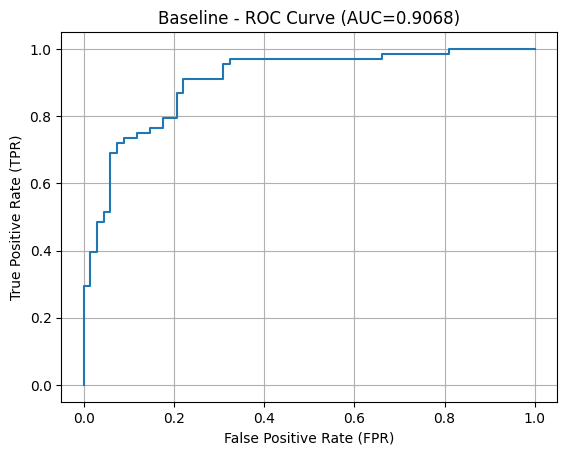

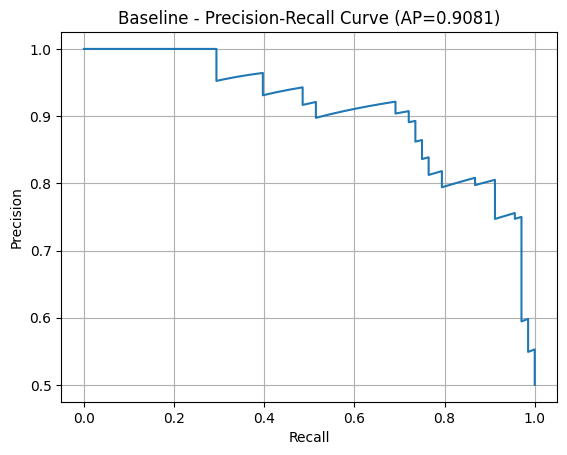

Baseline ROC-AUC: 0.9068
Baseline PR-AUC (Average Precision): 0.9081


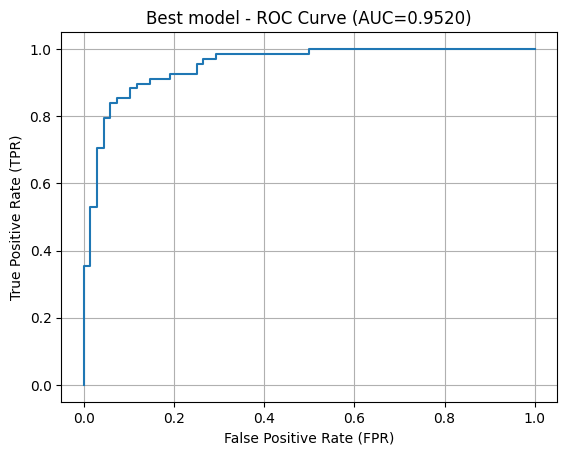

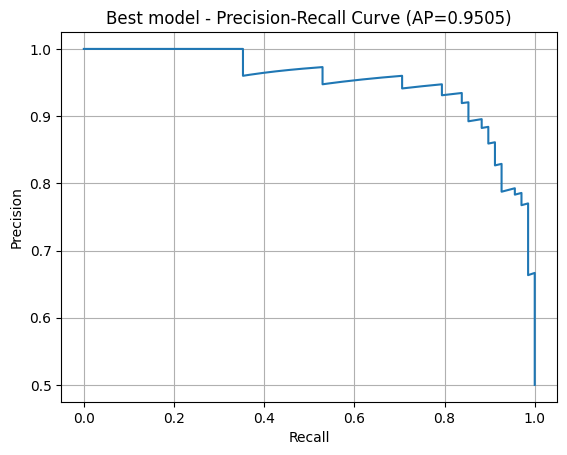

Best ROC-AUC: 0.9520
Best PR-AUC (Average Precision): 0.9505


In [11]:
import matplotlib.pyplot as plt
from sklearn.metrics import (
    roc_curve, auc,
    precision_recall_curve, average_precision_score
)

def plot_roc_pr(y_true, y_prob, title_prefix="Model"):
    # ---------------- ROC ----------------
    fpr, tpr, roc_thresholds = roc_curve(y_true, y_prob)  # thresholds που "σκανάρει" η καμπύλη
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr)
    plt.xlabel("False Positive Rate (FPR)")
    plt.ylabel("True Positive Rate (TPR)")
    plt.title(f"{title_prefix} - ROC Curve (AUC={roc_auc:.4f})")
    plt.grid(True)
    plt.show()

    # ------------- Precision-Recall -------------
    precision, recall, pr_thresholds = precision_recall_curve(y_true, y_prob)
    pr_auc = average_precision_score(y_true, y_prob)  # PR-AUC (Average Precision)

    plt.figure()
    plt.plot(recall, precision)
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"{title_prefix} - Precision-Recall Curve (AP={pr_auc:.4f})")
    plt.grid(True)
    plt.show()

    # ---------------------------------------------
    # Σχόλιο μέσα στον κώδικα:
    # roc_thresholds / pr_thresholds είναι τα κατώφλια πιθανότητας
    # που μεταβάλλονται αυτόματα για να παραχθούν οι καμπύλες.
    # ---------------------------------------------

    return roc_auc, pr_auc


# =========================
# 1) ΑΡΧΙΚΟ ΜΟΝΤΕΛΟ (baseline)
# =========================
# Χρησιμοποίησε τη μεταβλητή με τις πιθανότητες που ήδη έχεις:
# π.χ. y_prob = model.predict(X_test_p).ravel()
roc_auc_base, pr_auc_base = plot_roc_pr(y_test, y_prob, "Baseline")

print(f"Baseline ROC-AUC: {roc_auc_base:.4f}")
print(f"Baseline PR-AUC (Average Precision): {pr_auc_base:.4f}")

# =========================
# 2) ΚΑΛΥΤΕΡΟ ΜΟΝΤΕΛΟ (best)
# =========================
y_prob_best = best["test_prob"]
roc_auc_best, pr_auc_best = plot_roc_pr(y_test, y_prob_best, "Best model")

print(f"Best ROC-AUC: {roc_auc_best:.4f}")
print(f"Best PR-AUC (Average Precision): {pr_auc_best:.4f}")


ασκηση3

In [12]:
pip install ucimlrepo

In [13]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
breast_cancer_wisconsin_diagnostic = fetch_ucirepo(id=17)

# data (as pandas dataframes)
X = breast_cancer_wisconsin_diagnostic.data.features
y = breast_cancer_wisconsin_diagnostic.data.targets

# metadata
print(breast_cancer_wisconsin_diagnostic.metadata)

# variable information
print(breast_cancer_wisconsin_diagnostic.variables)


{'uci_id': 17, 'name': 'Breast Cancer Wisconsin (Diagnostic)', 'repository_url': 'https://archive.ics.uci.edu/dataset/17/breast+cancer+wisconsin+diagnostic', 'data_url': 'https://archive.ics.uci.edu/static/public/17/data.csv', 'abstract': 'Diagnostic Wisconsin Breast Cancer Database.', 'area': 'Health and Medicine', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 569, 'num_features': 30, 'feature_types': ['Real'], 'demographics': [], 'target_col': ['Diagnosis'], 'index_col': ['ID'], 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 1993, 'last_updated': 'Fri Nov 03 2023', 'dataset_doi': '10.24432/C5DW2B', 'creators': ['William Wolberg', 'Olvi Mangasarian', 'Nick Street', 'W. Street'], 'intro_paper': {'ID': 230, 'type': 'NATIVE', 'title': 'Nuclear feature extraction for breast tumor diagnosis', 'authors': 'W. Street, W. Wolberg, O. Mangasarian', 'venue': 'Electronic imaging', 'year': 1993, 'journal': None, 'DOI': '1

In [14]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

X, y = load_breast_cancer(return_X_y=True)

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.30,
    train_size=0.70,
    shuffle=True,
    stratify=y,
    random_state=42
)


In [15]:
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

X, y = load_breast_cancer(return_X_y=True)

seeds = range(1, 101)  # 100 διαφορετικά random splits
scores = []

for s in seeds:
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.30, stratify=y, random_state=s, shuffle=True
    )

    model = make_pipeline(
        StandardScaler(),
        LogisticRegression(max_iter=5000)
    )
    model.fit(X_train, y_train)

    prob = model.predict_proba(X_test)[:, 1]
    scores.append(roc_auc_score(y_test, prob))

scores = np.array(scores)
print("Mean ROC-AUC:", scores.mean())
print("Std ROC-AUC:", scores.std())
print("Min/Max ROC-AUC:", scores.min(), scores.max())


Mean ROC-AUC: 0.9949415887850467
Std ROC-AUC: 0.004256135893111547
Min/Max ROC-AUC: 0.9794100467289719 1.0


«Χρησιμοποιήθηκε stratified τυχαίος χωρισμός 70%/30% και το πείραμα επαναλήφθηκε για πολλαπλούς τυχαίους σπόρους. Η μέση τιμή ROC-AUC ήταν 0.9949 με τυπική απόκλιση 0.0043, ενώ οι τιμές κυμάνθηκαν από 0.9794 έως 1.0. Τα αποτελέσματα δείχνουν πολύ υψηλή και σταθερή διακριτική ικανότητα του μοντέλου, με μικρή ευαισθησία στον τυχαίο χωρισμό των δεδομένων.

In [16]:
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# 1) Load data
X, y = load_breast_cancer(return_X_y=True)

# 2) 70/30 stratified split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.30,
    stratify=y,
    shuffle=True,
    random_state=42
)

# 3) Introduce missing values in 10% of TRAINING cells uniformly at random
rng = np.random.default_rng(42)

X_train_missing = X_train.astype(float).copy()
mask = rng.random(X_train_missing.shape) < 0.10   # 10% of entries -> NaN
X_train_missing[mask] = np.nan

# 4) Pipeline: impute missing values + tree classifier (max depth 5)
model = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("tree", DecisionTreeClassifier(max_depth=5, random_state=42))
])

# 5) Train and evaluate on test set
model.fit(X_train_missing, y_train)
y_pred = model.predict(X_test)
acc = accuracy_score(y_test, y_pred)

print(f"Test accuracy: {acc:.4f}")
print(f"Missing rate actually injected (train cells): {mask.mean():.4f}")


Test accuracy: 0.9298
Missing rate actually injected (train cells): 0.0977


In [17]:
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# Data
X, y = load_breast_cancer(return_X_y=True)

# 70/30 split (stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, stratify=y, shuffle=True, random_state=42
)

# 10% missing uniformly at random ONLY in training cells
rng = np.random.default_rng(42)
X_train_miss = X_train.astype(float).copy()
mask = rng.random(X_train_miss.shape) < 0.10
X_train_miss[mask] = np.nan

# Pipeline: impute + tree depth 5
clf = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("tree", DecisionTreeClassifier(max_depth=5, random_state=42))
])

clf.fit(X_train_miss, y_train)

# Evaluate on test
y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)

print(f"Injected missing rate in train: {mask.mean():.4f}")
print(f"Test accuracy: {acc:.4f}")


Injected missing rate in train: 0.0977
Test accuracy: 0.9298


In [18]:
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Data
X, y = load_breast_cancer(return_X_y=True)

# ίδιο ακριβώς split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, stratify=y, shuffle=True, random_state=42
)

# ίδιο ακριβώς missing injection (10% uniformly) στο training
rng = np.random.default_rng(42)
X_train_miss = X_train.astype(float).copy()
mask = rng.random(X_train_miss.shape) < 0.10
X_train_miss[mask] = np.nan

# RF (χωρίς bootstrap) + imputation
rf = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("rf", RandomForestClassifier(
        n_estimators=100,
        max_depth=3,
        max_features=5,
        bootstrap=False,
        random_state=42,
        n_jobs=-1
    ))
])

rf.fit(X_train_miss, y_train)
y_pred = rf.predict(X_test)

acc = accuracy_score(y_test, y_pred)
print(f"Test accuracy (RF): {acc:.4f}")


Test accuracy (RF): 0.9298


In [19]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# --------------------
# 1) Data + same split
# --------------------
data = load_breast_cancer()
X, y = data.data, data.target
feature_names = data.feature_names

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, stratify=y, shuffle=True, random_state=42
)

# -------------------------------
# 2) Same 10% missing in training
# -------------------------------
rng = np.random.default_rng(42)
X_train_miss = X_train.astype(float).copy()
mask = rng.random(X_train_miss.shape) < 0.10
X_train_miss[mask] = np.nan

# --------------------
# 3) Models (pipelines)
# --------------------
tree_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("tree", DecisionTreeClassifier(max_depth=5, random_state=42))
])

rf_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("rf", RandomForestClassifier(
        n_estimators=100,
        max_depth=3,
        max_features=5,
        bootstrap=False,
        random_state=42,
        n_jobs=-1
    ))
])

# Fit
tree_pipe.fit(X_train_miss, y_train)
rf_pipe.fit(X_train_miss, y_train)

# Accuracies (για να τα έχεις μαζί)
tree_acc = accuracy_score(y_test, tree_pipe.predict(X_test))
rf_acc   = accuracy_score(y_test, rf_pipe.predict(X_test))
print(f"Tree test accuracy: {tree_acc:.4f}")
print(f"RF   test accuracy: {rf_acc:.4f}")

# -----------------------------------------
# 4) Feature importances (impurity-based)
# -----------------------------------------
tree_imp = tree_pipe.named_steps["tree"].feature_importances_
rf_imp   = rf_pipe.named_steps["rf"].feature_importances_

def topk(imp, k=10):
    s = pd.Series(imp, index=feature_names).sort_values(ascending=False)
    return s.head(k)

print("\nTop-10 Tree importances:\n", topk(tree_imp, 10))
print("\nTop-10 RF   importances:\n", topk(rf_imp, 10))


Tree test accuracy: 0.9298
RF   test accuracy: 0.9298

Top-10 Tree importances:
 worst radius            0.655004
worst concave points    0.174486
mean area               0.041963
concave points error    0.031261
worst concavity         0.028345
mean radius             0.016806
mean texture            0.014939
worst texture           0.013445
area error              0.013205
mean concave points     0.008064
dtype: float64

Top-10 RF   importances:
 worst area              0.185141
worst radius            0.117182
worst concave points    0.109954
mean concave points     0.109178
mean radius             0.074233
worst perimeter         0.073359
mean area               0.072634
mean perimeter          0.065033
worst concavity         0.049241
mean concavity          0.037433
dtype: float64


Accuracy grid (rows=train missing, cols=test missing):
[[0.92982456 0.93567251 0.9122807  0.92397661 0.9005848  0.87134503
  0.76608187 0.70175439 0.65497076]
 [0.9122807  0.92397661 0.90643275 0.93567251 0.9122807  0.87719298
  0.83625731 0.78362573 0.71345029]
 [0.92397661 0.92397661 0.92397661 0.92982456 0.92982456 0.89473684
  0.85380117 0.80116959 0.76023392]
 [0.92982456 0.94152047 0.91812865 0.95321637 0.94152047 0.88888889
  0.87134503 0.8245614  0.76608187]
 [0.92982456 0.92982456 0.92397661 0.95321637 0.93567251 0.89473684
  0.87134503 0.8245614  0.77777778]
 [0.9122807  0.91812865 0.91812865 0.94152047 0.92982456 0.90643275
  0.87134503 0.83040936 0.8128655 ]
 [0.90643275 0.9005848  0.90643275 0.92397661 0.9122807  0.9005848
  0.88304094 0.85380117 0.79532164]
 [0.9122807  0.9122807  0.90643275 0.92397661 0.91812865 0.91812865
  0.87719298 0.85380117 0.78947368]
 [0.85380117 0.86549708 0.87719298 0.87134503 0.88888889 0.88888889
  0.85964912 0.85380117 0.84210526]]


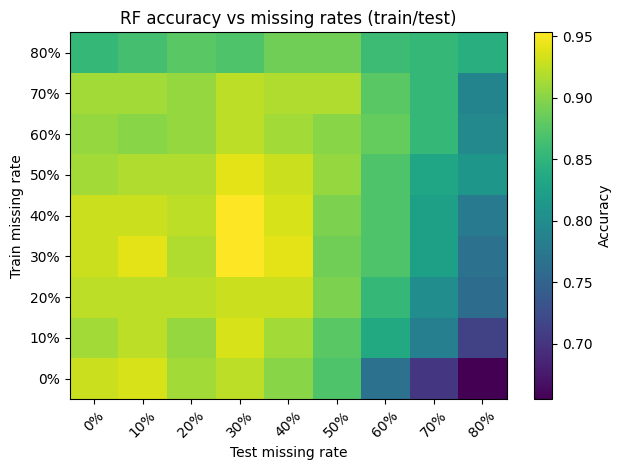

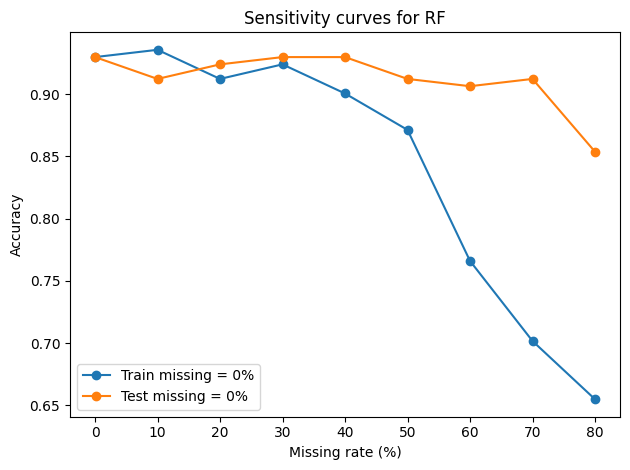

In [20]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# --------------------
# 1) Data + fixed split
# --------------------
X, y = load_breast_cancer(return_X_y=True)

X_train0, X_test0, y_train, y_test = train_test_split(
    X, y, test_size=0.30, stratify=y, shuffle=True, random_state=42
)

# --------------------
# 2) Helpers
# --------------------
def inject_missing_uniform(X_in, missing_rate, rng):
    """Turn missing_rate fraction of cells into NaN uniformly at random."""
    X_out = X_in.astype(float).copy()
    if missing_rate <= 0:
        return X_out
    mask = rng.random(X_out.shape) < missing_rate
    X_out[mask] = np.nan
    return X_out

def make_rf_pipeline():
    return Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("rf", RandomForestClassifier(
            n_estimators=100,
            max_depth=3,
            max_features=5,
            bootstrap=False,
            random_state=42,
            n_jobs=-1
        ))
    ])

# --------------------
# 3) Experiment grid
# --------------------
rates = np.arange(0.0, 0.81, 0.10)  # 0%..80% step 10%
acc = np.zeros((len(rates), len(rates)))

# (Optional) for stability: fixed RNG seeds per condition (reproducible)
base_seed = 12345

for i, tr in enumerate(rates):
    # inject missing into TRAIN
    rng_tr = np.random.default_rng(base_seed + i)
    X_train = inject_missing_uniform(X_train0, tr, rng_tr)

    # train model for this train-missing level
    model = make_rf_pipeline()
    model.fit(X_train, y_train)

    for j, te in enumerate(rates):
        # inject missing into TEST
        rng_te = np.random.default_rng(base_seed + 100 + 10*j)
        X_test = inject_missing_uniform(X_test0, te, rng_te)

        # evaluate
        y_pred = model.predict(X_test)
        acc[i, j] = accuracy_score(y_test, y_pred)

print("Accuracy grid (rows=train missing, cols=test missing):")
print(acc)

# --------------------
# 4) Plot: Heatmap
# --------------------
plt.figure()
plt.imshow(acc, origin="lower", aspect="auto")
plt.colorbar(label="Accuracy")
plt.xticks(range(len(rates)), [f"{int(r*100)}%" for r in rates], rotation=45)
plt.yticks(range(len(rates)), [f"{int(r*100)}%" for r in rates])
plt.xlabel("Test missing rate")
plt.ylabel("Train missing rate")
plt.title("RF accuracy vs missing rates (train/test)")
plt.tight_layout()
plt.show()

# --------------------
# 5) Plot: two summary curves
#    (a) varying test-missing when train-missing=0
#    (b) varying train-missing when test-missing=0
# --------------------
plt.figure()
plt.plot([int(r*100) for r in rates], acc[0, :], marker="o", label="Train missing = 0%")
plt.plot([int(r*100) for r in rates], acc[:, 0], marker="o", label="Test missing = 0%")
plt.xlabel("Missing rate (%)")
plt.ylabel("Accuracy")
plt.title("Sensitivity curves for RF")
plt.legend()
plt.tight_layout()
plt.show()


Average Precision (Tree): 0.9291
Average Precision (RF):   0.9921


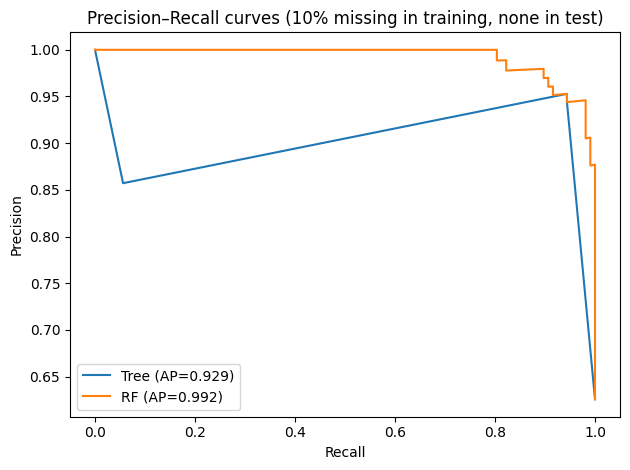

In [21]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_curve, average_precision_score

# 1) Load + split (fixed)
X, y = load_breast_cancer(return_X_y=True)
X_train0, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, stratify=y, shuffle=True, random_state=42
)

# 2) Inject 10% missing in TRAIN only (uniform over cells)
rng = np.random.default_rng(42)
X_train = X_train0.astype(float).copy()
mask = rng.random(X_train.shape) < 0.10
X_train[mask] = np.nan

# 3) Pipelines
tree = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("clf", DecisionTreeClassifier(max_depth=5, random_state=42))
])

rf = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("clf", RandomForestClassifier(
        n_estimators=100,
        max_depth=3,
        max_features=5,
        bootstrap=False,
        random_state=42,
        n_jobs=-1
    ))
])

# 4) Fit
tree.fit(X_train, y_train)
rf.fit(X_train, y_train)

# 5) Scores for PR curves (probability of class 1)
tree_scores = tree.predict_proba(X_test)[:, 1]
rf_scores   = rf.predict_proba(X_test)[:, 1]

# 6) PR curves + Average Precision (area under PR)
p_t, r_t, _ = precision_recall_curve(y_test, tree_scores)
p_f, r_f, _ = precision_recall_curve(y_test, rf_scores)

ap_tree = average_precision_score(y_test, tree_scores)
ap_rf   = average_precision_score(y_test, rf_scores)

print(f"Average Precision (Tree): {ap_tree:.4f}")
print(f"Average Precision (RF):   {ap_rf:.4f}")

# 7) Plot
plt.figure()
plt.plot(r_t, p_t, label=f"Tree (AP={ap_tree:.3f})")
plt.plot(r_f, p_f, label=f"RF (AP={ap_rf:.3f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall curves (10% missing in training, none in test)")
plt.legend()
plt.tight_layout()
plt.show()
